<a href="https://colab.research.google.com/github/AlinaLevitin/MRI_tumour_detection/blob/main/MRI_tumour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRI Tumor Detection**

This dataset contains 253 images of brains with and without tumors.
I built a small deep learning model in order to predict pressence or tumor.
I chose [this dataset from Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) since it fits in the drive.
Its unrelaible to use it as tumor prediction!

For better prediction I used a [second dataset from Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) containing 3000 images of brain MRI with or without tumors in pycharm.

### **Importing the relevant packages**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import imutils
import numpy as np
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

### **Viewing the data**

In [3]:
# Setup paths to our data directory

dir_path = "/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/brain_tumor_dataset"

In [4]:
def view_random_images(target_dir, target_classes=('yes', 'no'), img_num=25):
  """
  function to veiw a bulk of images of both classes
  """
    
  # making a figure for each class
  for target_class in target_classes:
    
    # set the target directory
    target_folder = target_dir + '/' + target_class

    # Set up a figure
    plt.figure()

    # Get random image paths according to the number of images chosen in img_num
    random_images = random.sample(os.listdir(target_folder), img_num)

    # Read in the image and plot it using matplotlib
    for index, image in enumerate(random_images):
      plt.subplot(5, 5, index+1)
      plt.imshow(mpimg.imread(target_folder + "/" + image))

      # remnving the axis
      plt.axis('off')
    
    # setting the title according to the class
    plt.suptitle(f'Tumor: {target_class}', fontsize=20)

    plt.show()

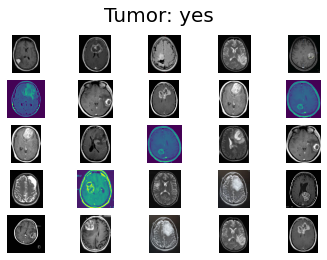

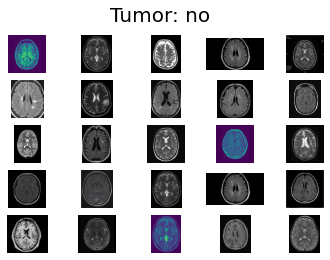

In [5]:
view_random_images(dir_path)

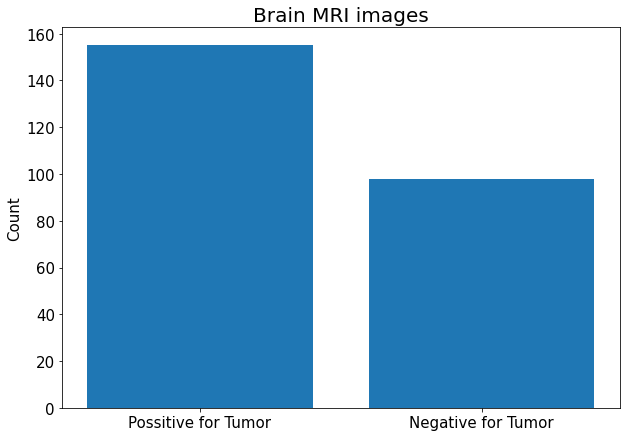

In [6]:
# plot the number of images
yes_images = os.listdir(dir_path + '/' + 'yes')
no_images = os.listdir(dir_path + '/' + 'no')

num_yes_images = len(yes_images)
num_no_images = len(no_images)

plt.figure(figsize=(10, 7))
plt.bar(('Possitive for Tumor', 'Negative for Tumor'), (num_yes_images, num_no_images))
plt.title('Brain MRI images', fontsize=20)
plt.ylabel('Count', fontsize=15)
plt.tick_params(labelsize=15)

## **Preprocessign data**

### Cropping (from [1](https://www.kaggle.com/code/ashuvssut/brain-tumor-detection-cnn) and [2](https://www.kaggle.com/code/asubasi/brain-tumor-detection-mobilenet-v2))

In [7]:
def crop_image(image):
  """
  Function to crop images
  """
  # convert to 8 bit image
  image_8bit = cv2.convertScaleAbs(image)    

  gray = image_8bit

  # Convert the image to grayscale
  if len(image_8bit.shape) == 3:
    if image_8bit.shape[2] != 1:
      gray = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2GRAY)

  # Apply a Gaussian blur to the image
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # Threshold the image by Binary Thresholding
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

  # perform a series of erosions & dilations to remove any small regions of noise
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea, default=0)
  
  # find the extreme points
  if not isinstance(c, int):
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
  # crop
    new_img = image_8bit[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

    return new_img
  else:
    return image_8bit

In [8]:
def crop_all_images(target_dir, target_classes=('yes', 'no')):
  """
  Function to crop all images in all classes
  """
  # for both classes
  for target_class in target_classes:

    # making a list of all the images
    images = os.listdir(dir_path + '/' + target_class)

    #cropping all images in the list
    for image in images:

      #reading the image
      image_read = mpimg.imread(dir_path + '/' + target_class + '/' + image)

      #showing the cropped image (was good to catch errors with some of the images)
      plt.axis('off')
      plt.imshow(crop_image(image_read))

      # setting the working directory
      os.chdir(target_dir)
      os.chdir("..")
      cwd = os.getcwd()

      # making a new directory for cropped images
      new_path = '/cropped_brain_tumor_dataset/' + target_class
      os.makedirs(cwd + new_path, exist_ok=True)
      os.chdir(cwd + new_path)

      # parsing the name of the image
      name = image.split('.')[0]

      # saving the image in the selected folder
      plt.savefig(f'{name}.png', format='png')

In [9]:
# crop all images into a new dir (need to run only once - it takes a lot of time)
# crop_all_images(dir_path)

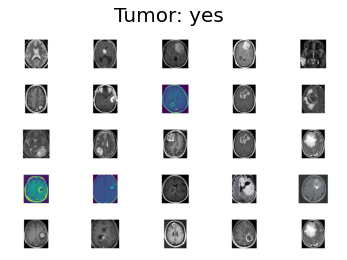

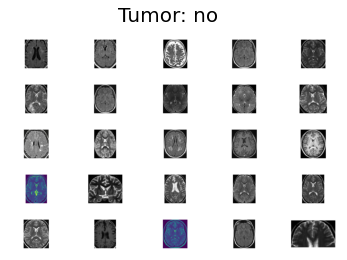

In [10]:
view_random_images('/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/cropped_brain_tumor_dataset')

In [11]:
yes_images = os.listdir('/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/cropped_brain_tumor_dataset/yes')
image = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/cropped_brain_tumor_dataset/yes' + "/" + yes_images[0])
image.shape

(288, 432, 4)

## **Loading the Data**

In [12]:
tf.random.set_seed(42)

# preprocess data (scale)
train_datagen = ImageDataGenerator(rescale=1./255,
                              validation_split=0.2,
                              # rotation_range=15,
                              # width_shift_range=0.1,
                              # height_shift_range=0.1,
                              shear_range=0.1,
                              brightness_range=[0.5, 1.5],
                              horizontal_flip=True,
                              vertical_flip=True
                             )

test_datagen = ImageDataGenerator(rescale=1./255)


cropped_data = '/content/drive/MyDrive/Colab Notebooks/MiniProjects/MRI_tumour_detection/data/cropped_brain_tumor_dataset'

# Import data from directories and trun it into batches with augmented data
training_data = train_datagen.flow_from_directory(directory=cropped_data, batch_size=32, target_size=(224, 224), class_mode='binary', subset="training", seed=42)
validation_data = train_datagen.flow_from_directory(directory=cropped_data, batch_size=32, target_size=(224, 224), class_mode='binary', subset="validation", seed=42)


test_data = test_datagen.flow_from_directory(directory=cropped_data, batch_size=32, target_size=(224, 224), class_mode='binary', seed=42)

Found 203 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 252 images belonging to 2 classes.


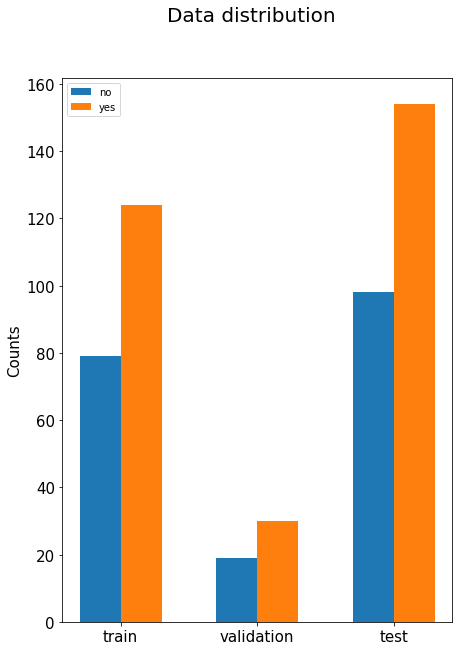

In [74]:
# plot the statistics

# get the velue counts
train_no = np.unique(training_data.classes, return_counts=True)[1][0]
train_yes = np.unique(training_data.classes, return_counts=True)[1][1]

val_no = np.unique(validation_data.classes, return_counts=True)[1][0]
val_yes = np.unique(validation_data.classes, return_counts=True)[1][1]

test_no = np.unique(test_data.classes, return_counts=True)[1][0]
test_yes = np.unique(test_data.classes, return_counts=True)[1][1]

# set up the data and the labels
values_no = [train_no, val_no, test_no]
values_yes = [train_yes, val_yes, test_yes]

labels = ['train', 'validation', 'test']

# create a new figure
fig, ax = plt.subplots(1, figsize=(7, 10), sharey=True)
fig.suptitle('Data distribution', fontsize=20)

# set up the colun width
width = 0.6

# plot the data
ax.bar(labels, values_no, label='no', width=width)
ax.bar(labels, values_yes, label='yes', width=width/2, align="edge")

# make title, and axis
ax.set_ylabel('Counts', fontsize=15)
plt.tick_params(labelsize=15)
plt.legend()

plt.show()

## **Train the model with the data**

In [75]:
# BUILD CNN:
epochs = 18


# construct the model
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
                                      ])

# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


In [76]:
# fit the data
history_1 = model_1.fit(training_data, epochs=epochs, steps_per_epoch=len(training_data), validation_data=validation_data, validation_steps=len(validation_data))

Epoch 1/18
7/7 [==============================] - 27s 4s/step - loss: 0.6887 - accuracy: 0.6108 - val_loss: 0.6527 - val_accuracy: 0.6122
Epoch 2/18
7/7 [==============================] - 19s 3s/step - loss: 0.6715 - accuracy: 0.6108 - val_loss: 0.6681 - val_accuracy: 0.6122
Epoch 3/18
7/7 [==============================] - 19s 3s/step - loss: 0.6668 - accuracy: 0.6108 - val_loss: 0.6701 - val_accuracy: 0.6122
Epoch 4/18
7/7 [==============================] - 19s 3s/step - loss: 0.6667 - accuracy: 0.6108 - val_loss: 0.6582 - val_accuracy: 0.6122
Epoch 5/18
7/7 [==============================] - 19s 3s/step - loss: 0.6643 - accuracy: 0.6108 - val_loss: 0.6679 - val_accuracy: 0.6122
Epoch 6/18
7/7 [==============================] - 19s 3s/step - loss: 0.6684 - accuracy: 0.6158 - val_loss: 0.6690 - val_accuracy: 0.6122
Epoch 7/18
7/7 [==============================] - 19s 3s/step - loss: 0.6521 - accuracy: 0.6158 - val_loss: 0.6544 - val_accuracy: 0.6122
Epoch 8/18
7/7 [==================

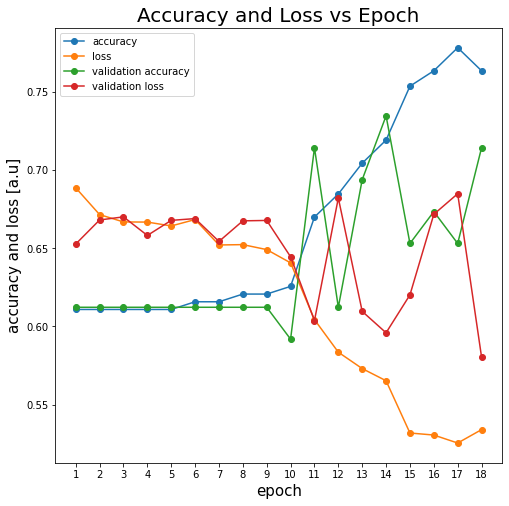

In [77]:
# plot the accuracy and loss vs epoch

# making a new figure
plt.figure(figsize=(8, 8))

# setting the x ticks
ticks = [i for i in range(1,epochs+1)]

# ploting the accuracy and loss from the training
plt.plot(ticks, history_1.history['accuracy'], label='accuracy', marker='o')
plt.plot(ticks, history_1.history['loss'], label='loss', marker='o')
plt.plot(ticks, history_1.history['val_accuracy'], label='validation accuracy', marker='o')
plt.plot(ticks, history_1.history['val_loss'], label='validation loss', marker='o')

# setting labels and title
plt.title('Accuracy and Loss vs Epoch', fontsize=20)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('accuracy and loss [a.u]', fontsize=15)
plt.xticks(ticks, ticks)

# showing the legend
plt.legend()

# showing the plot
plt.show()

In [78]:
# evaluating on the whole data since the dataset is tiny!
model_1.evaluate(test_data)

8/8 [==============================] - 7s 786ms/step - loss: 0.5302 - accuracy: 0.7222


[0.5302133560180664, 0.7222222089767456]

8/8 [==============================] - 8s 783ms/step


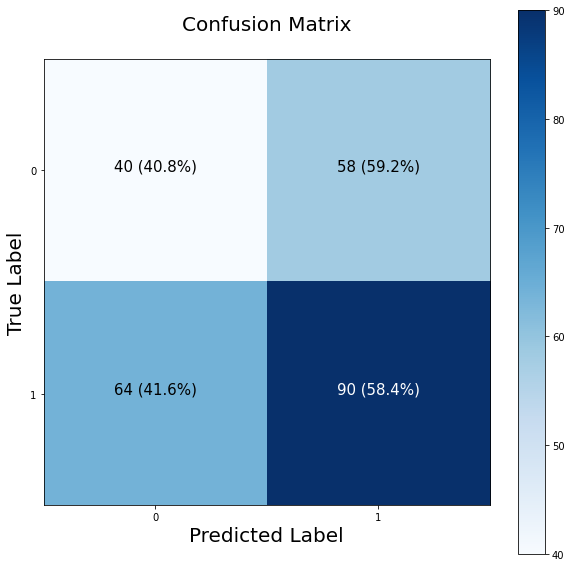

In [79]:
# making a confussion matrix
figsize = (10, 10)

# making prediction on the data
y_pred = model_1.predict(test_data)

# the true labels
y_true = test_data.labels

# confussion matrix
cm = confusion_matrix(y_true, tf.round(y_pred))

# normalizing the confussion matrix for parcentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# setting the number of classes (should be 2)
n_classes = cm[0].shape[0]

# creating a new figure
fig, ax =plt.subplots(figsize=figsize)

# setting the color map (blue)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# setting up the labes (1 and 0)
labels = np.arange(cm.shape[0])

ax.set(title="Confusion Matrix",
       xlabel='Predicted Label',
       ylabel='True Label',
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)